In [1]:
!git clone https://github.com/jorgpg5/synthetic_data.git

fatal: destination path 'synthetic_data' already exists and is not an empty directory.


# Synthesize Time Series data from your own DataFrame

This Blueprint demonstrates how to create synthetic time series data with Gretel. We assume that within the dataset
there is at least:

1) A specific column holding time data points

2) One or more columns that contain measurements or numerical observations for each point in time.

For this Blueprint, we will generate a very simple sine wave as our time series data.

In [2]:
%%capture

!pip install pyyaml smart_open numpy pandas
!pip install -U gretel-client

In [3]:
# Specify your Gretel API key

from getpass import getpass
import pandas as pd
from gretel_client import configure_session, ClientConfig

pd.set_option('max_colwidth', None)

configure_session(ClientConfig(api_key=getpass(prompt="Enter Gretel API key"), 
                               endpoint="https://api.gretel.cloud"))

Enter Gretel API key··········


In [19]:
# Create a simple timeseries with a sine and cosine wave

import datetime
import pandas as pd
import numpy as np

train_df = pd.read_csv('/content/synthetic_data/example_dataset.csv')

train_df

,EDA,ECG,Label,Left Pupil Diameter (m),Right Pupil Diameter (m),Eye Opening Left,Eye Opening Right,PERCLOS Value,Blinking
0,4.3114,-0.1822,2,0.002089,0.002242,0.4522,0.4111,0.5904,0
1,4.3129,-0.1535,2,0.002101,0.002183,0.4679,0.4372,0.5904,0
2,4.3120,-0.1209,2,0.002115,0.002224,0.4489,0.4276,0.5903,0
3,4.3129,-0.0918,2,0.002274,0.002392,0.5027,0.4294,0.5902,0
4,4.3116,-0.0696,2,0.002195,0.002318,0.4237,0.4388,0.5902,0
...,...,...,...,...,...,...,...,...,...
17995,5.0606,-0.0341,2,0.002624,0.002474,0.1496,0.0798,0.4570,0
17996,5.0598,0.0034,2,0.002624,0.002474,0.1496,0.0949,0.4570,0
17997,5.0613,0.0277,2,0.002624,0.002474,0.1496,0.0974,0.4571,0
17998,5.0589,0.0610,2,0.002624,0.002474,0.1496,0.0834,0.4571,0


In [22]:
train_df['idx_col'] = train_df.index
train_df

,EDA,ECG,Label,Left Pupil Diameter (m),Right Pupil Diameter (m),Eye Opening Left,Eye Opening Right,PERCLOS Value,Blinking,idx_col
0,4.3114,-0.1822,2,0.002089,0.002242,0.4522,0.4111,0.5904,0,0
1,4.3129,-0.1535,2,0.002101,0.002183,0.4679,0.4372,0.5904,0,1
2,4.3120,-0.1209,2,0.002115,0.002224,0.4489,0.4276,0.5903,0,2
3,4.3129,-0.0918,2,0.002274,0.002392,0.5027,0.4294,0.5902,0,3
4,4.3116,-0.0696,2,0.002195,0.002318,0.4237,0.4388,0.5902,0,4
...,...,...,...,...,...,...,...,...,...,...
17995,5.0606,-0.0341,2,0.002624,0.002474,0.1496,0.0798,0.4570,0,17995
17996,5.0598,0.0034,2,0.002624,0.002474,0.1496,0.0949,0.4570,0,17996
17997,5.0613,0.0277,2,0.002624,0.002474,0.1496,0.0974,0.4571,0,17997
17998,5.0589,0.0610,2,0.002624,0.002474,0.1496,0.0834,0.4571,0,17998


In [6]:

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=9, cols=1)

fig.append_trace(go.Scatter(
    y=train_df.EDA,
    name='EDA',
), row=1, col=1)

fig.append_trace(go.Scatter(
    y=train_df.ECG,
    name='ECG',
), row=2, col=1)

fig.append_trace(go.Scatter(
    y=train_df.Label,
    name='Label',
), row=3, col=1)

fig.append_trace(go.Scatter(
    y=train_df['Left Pupil Diameter (m)'],
    name='Left pupil diameter',
), row=4, col=1)

fig.append_trace(go.Scatter(
    y=train_df['Right Pupil Diameter (m)'],
    name='Right pupil diameter',
), row=5, col=1)

fig.append_trace(go.Scatter(
    y=train_df['Eye Opening Left'],
    name='Eye Opening Left',
), row=6, col=1)

fig.append_trace(go.Scatter(
    y=train_df['Eye Opening Right'],
    name='Eye Opening Right',
), row=7, col=1)

fig.append_trace(go.Scatter(
    y=train_df['PERCLOS Value'],
    name='PERCLOS',
), row=8, col=1)

fig.append_trace(go.Scatter(
    y=train_df.Blinking,
    name='Blink',
), row=9, col=1)

fig.update_layout(height=1200, width=1200, title_text="Individual channels")
fig.show()

In [7]:
def train_and_gen_syn_data(config, train_df, project):
    model = project.create_model_obj(model_config=config)

    # Get a csv to work with, just dump out the train_df.
    train_df.to_csv('train.csv', index=False)
    model.data_source = 'train.csv'

    # Upload the training data.  Train the model.
    model.submit(upload_data_source=True)

    poll(model)

    # Use the model to generate synthetic data.
    record_handler = model.create_record_handler_obj()

    # For time series data we dump out the date column to seed the record handler.
    train_df['idx_col'].to_csv('idx_seeds.csv', index=False)

    record_handler.submit(
        action="generate",
        params={"num_records": 18000, "max_invalid": 20000},
        data_source='idx_seeds.csv',
        upload_data_source=True
    )

    poll(record_handler)

    synthetic = pd.read_csv(record_handler.get_artifact_link("data"), compression='gzip')

    return synthetic

In [8]:
from smart_open import open
import yaml

from gretel_client import create_project
from gretel_client.helpers import poll

# Pull down the default synthetic config.  We will modify it slightly.
with open("https://raw.githubusercontent.com/gretelai/gretel-blueprints/main/config_templates/gretel/synthetics/default.yml", 'r') as stream:
    config = yaml.safe_load(stream)

# Here we create an object to specify the timeseries task.
time_field="idx_col"
trend_fields=["EDA", "ECG", "Left Pupil Diameter (m)", "Right Pupil Diameter (m)", "Eye Opening Left", "Eye Opening Right", "PERCLOS Value", "Blinking"]

task = {
    'type': 'time_series',
    'attrs': {
        'time_field': time_field,
        'trend_fields': trend_fields
    }
}

config['models'][0]['synthetics']['task'] = task
config['models'][0]['synthetics']['params']['predict_batch_size'] = 1
config['models'][0]['synthetics']['params']['overwrite'] = True

# At the moment (17/08/2021), validation split doesn't support time series tasks yet. Updated config will be uploaded soon
config['models'][0]['synthetics']['params']['validation_split'] = False

#### Applying the parameters for test 1: Original data

In [9]:
# Create a project and model configuration.
project = create_project(display_name="time-series-synthetic_test1_orig_data")

# Modifying some values
config['models'][0]['synthetics']['params']['vocab_size'] = 28
config['models'][0]['synthetics']['params']['rnn_units'] = 64
config['models'][0]['synthetics']['params']['dropout_rate'] = 0.5
config['models'][0]['synthetics']['params']['gen_temp'] = .898
config['models'][0]['synthetics']['params']['learning_rate'] = .0035
config['models'][0]['synthetics']['params']['reset_states'] = True

syn_test1 = train_and_gen_syn_data(config, train_df, project)

INFO: Starting poller


{
    "uid": "611b5f399af4344d9eeb8d88",
    "model_name": "embarrassed-mighty-jackal",
    "runner_mode": "cloud",
    "user_id": "60f7ffc2bff621796155eab8",
    "project_id": "611b5f2e31fdb5cc987970db",
    "logs": null,
    "status_history": {
        "created": "2021-08-17T07:03:21.858024Z"
    },
    "last_modified": "2021-08-17T07:03:22.055651Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/synthetics@sha256:b3e13e4cef5ffebff4251a6cd838a879ce539b05c649e517e6c45a1ba1a0d431",
    "model_type": "synthetics",
    "config": {
        "schema_version": "1.0",
        "name": null,
        "models": [
            {
                "synthetics": {
                    "params": {
                        "field_delimiter": null,
                        "epochs": 100,
                        "batch_size": 64,


INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2021-08-17T07:03:35.228926Z  Starting synthetic model training
2021-08-17T07:03:35.230784Z  Loading training data
2021-08-17T07:03:35.509365Z  Training data loaded
{
    "record_count": 18000,
    "field_count": 10
}
2021-08-17T07:03:41.765841Z  Creating semantic validators and preparing training data
2021-08-17T07:03:49.936128Z  Beginning ML model training
2021-08-17T07:04:19.216387Z  Training epoch completed
{
    "epoch": 0,
    "accuracy": 0.5216,
    "loss": 1.6947,
    "val_accuracy": 0,
    "val_loss": 0,
    "batch": 0
}
2021-08-17T07:04:22.353707Z  Training epoch completed
{
    "epoch": 1,
    "accuracy": 0.6128,
    "loss": 1.2463,
    "val_accuracy": 0,
    "val_loss": 0,
    "batch": 0
}
2021-08-17T07:04:25.521920Z  Training epoch completed
{
    "epoch": 2,
    "accuracy": 0.6262,
    "loss": 1.1663,
    "val_accuracy

{
    "uid": "611b6253059876a22ea99955",
    "model_name": null,
    "runner_mode": "cloud",
    "user_id": "60f7ffc2bff621796155eab8",
    "project_id": "611b5f2e31fdb5cc987970db",
    "logs": null,
    "status_history": {
        "created": "2021-08-17T07:16:35.610000Z"
    },
    "last_modified": "2021-08-17T07:16:35.694000Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/synthetics@sha256:b3e13e4cef5ffebff4251a6cd838a879ce539b05c649e517e6c45a1ba1a0d431",
    "model_id": "611b5f399af4344d9eeb8d88",
    "action": "generate",
    "config": {
        "data_source": "gretel_376aed6d923049f79d7cdae40027e314_idx_seeds.csv",
        "params": {
            "num_records": 18000,
            "max_invalid": 20000
        }
    }
}


INFO: Status is created. A Record generation job has been queued.
INFO: Status is pending. A Gretel Cloud worker is being allocated to begin generating synthetic records.
INFO: Status is active. A worker has started!
2021-08-17T07:16:48.816821Z  Downloading model to worker
2021-08-17T07:16:49.093547Z  Checking for synthetic smart seeds
2021-08-17T07:16:49.322876Z  Loaded 18000 smart seeds for generation
2021-08-17T07:16:49.323931Z  Loading model
2021-08-17T07:16:50.900357Z  Generating records
{
    "num_records": 18000
}
2021-08-17T07:16:55.925870Z  Generation in progress
{
    "current_valid_count": 34,
    "current_invalid_count": 78,
    "new_valid_count": 34,
    "new_invalid_count": 78,
    "completion_percent": 0.19
}
2021-08-17T07:17:00.932952Z  Generation in progress
{
    "current_valid_count": 121,
    "current_invalid_count": 110,
    "new_valid_count": 87,
    "new_invalid_count": 32,
    "completion_percent": 0.67
}
2021-08-17T07:17:05.937966Z  Generation in progress
{
   

In [10]:
syn_test1.head()

,EDA,ECG,Label,Left Pupil Diameter (m),Right Pupil Diameter (m),Eye Opening Left,Eye Opening Right,PERCLOS Value,Blinking,idx_col
0,4.3114,-0.1822,2,0.002089,0.002242,0.4522,0.4111,0.5904,0.0,0
1,4.3123,-0.1694,2,0.002089,0.002242,0.4522,0.4111,0.5903,0.0,1
2,4.3110,-0.1486,2,0.002089,0.002242,0.4694,0.4111,0.5903,0.0,2
3,4.3103,-0.1262,2,0.002089,0.002242,0.4694,0.4101,0.5903,0.0,3
4,4.3099,-0.1233,2,0.002089,0.002242,0.4694,0.3946,0.5903,0.0,4


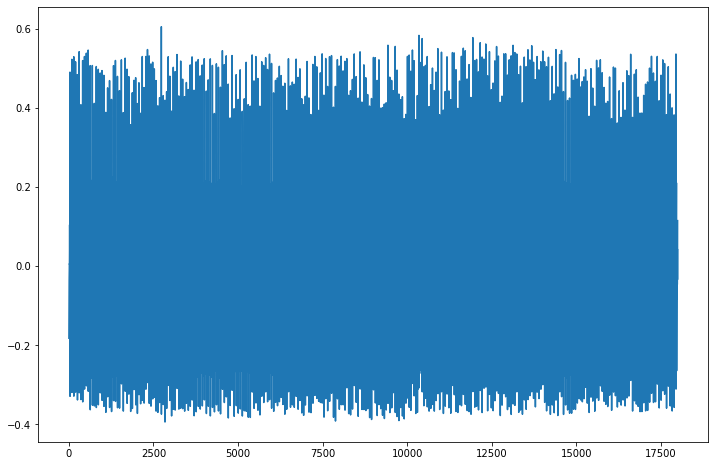

In [11]:
train_df.ECG.plot(figsize=(12, 8))

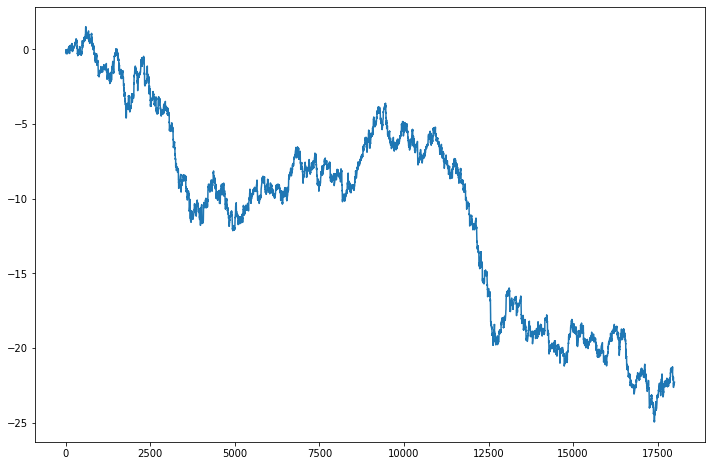

In [12]:
syn_test1.ECG.plot(figsize=(12, 8))

#### Applying the parameters for test 2: scaled data

In [ ]:
# Scaling data to have integer numbers
scaled_train_df[["EDA", "ECG", "Eye Opening Left", "Eye Opening Right", "PERCLOS Value"]] = train_df[["EDA", "ECG", "Eye Opening Left", "Eye Opening Right", "PERCLOS Value"]] * 1e4
scaled_train_df[["Left Pupil Diameter (m)", "Right Pupil Diameter (m)"]] = train_df[["Left Pupil Diameter (m)", "Right Pupil Diameter (m)"]] * 1e6    

In [13]:
# Create a project and model configuration.
project = create_project(display_name="time-series-synthetic_test2_scaled_data")

# Modifying some values
config['models'][0]['synthetics']['params']['vocab_size'] = 18
config['models'][0]['synthetics']['params']['rnn_units'] = 64
config['models'][0]['synthetics']['params']['dropout_rate'] = 0.629
config['models'][0]['synthetics']['params']['gen_temp'] = 1.0
config['models'][0]['synthetics']['params']['learning_rate'] = .0099
config['models'][0]['synthetics']['params']['reset_states'] = False

syn_test2 = train_and_gen_syn_data(config, scaled_train_df, project)

INFO: Starting poller


{
    "uid": "611b65ad592ecd251586042b",
    "model_name": "goofy-mysterious-jackal",
    "runner_mode": "cloud",
    "user_id": "60f7ffc2bff621796155eab8",
    "project_id": "611b65a2c9c21f5fa66477a9",
    "logs": null,
    "status_history": {
        "created": "2021-08-17T07:30:53.679221Z"
    },
    "last_modified": "2021-08-17T07:30:53.949113Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/synthetics@sha256:b3e13e4cef5ffebff4251a6cd838a879ce539b05c649e517e6c45a1ba1a0d431",
    "model_type": "synthetics",
    "config": {
        "schema_version": "1.0",
        "name": null,
        "models": [
            {
                "synthetics": {
                    "params": {
                        "field_delimiter": null,
                        "epochs": 100,
                        "batch_size": 64,
  

INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2021-08-17T07:31:07.185120Z  Starting synthetic model training
2021-08-17T07:31:07.187014Z  Loading training data
2021-08-17T07:31:07.486456Z  Training data loaded
{
    "record_count": 18000,
    "field_count": 10
}
2021-08-17T07:31:13.704029Z  Creating semantic validators and preparing training data
2021-08-17T07:31:21.366751Z  Beginning ML model training
2021-08-17T07:31:40.551338Z  Training epoch completed
{
    "epoch": 0,
    "accuracy": 0.6145,
    "loss": 1.306,
    "val_accuracy": 0,
    "val_loss": 0,
    "batch": 0
}
2021-08-17T07:31:43.625209Z  Training epoch completed
{
    "epoch": 1,
    "accuracy": 0.7126,
    "loss": 0.944,
    "val_accuracy": 0,
    "val_loss": 0,
    "batch": 0
}
2021-08-17T07:31:46.643340Z  Training epoch completed
{
    "epoch": 2,
    "accuracy": 0.719,
    "loss": 0.9013,
    "val_accuracy": 

{
    "uid": "611b6882a6b56212efae3c13",
    "model_name": null,
    "runner_mode": "cloud",
    "user_id": "60f7ffc2bff621796155eab8",
    "project_id": "611b65a2c9c21f5fa66477a9",
    "logs": null,
    "status_history": {
        "created": "2021-08-17T07:42:58.579000Z"
    },
    "last_modified": "2021-08-17T07:42:58.735000Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/synthetics@sha256:b3e13e4cef5ffebff4251a6cd838a879ce539b05c649e517e6c45a1ba1a0d431",
    "model_id": "611b65ad592ecd251586042b",
    "action": "generate",
    "config": {
        "data_source": "gretel_3a27400aa25e409a80deec233b06f53f_idx_seeds.csv",
        "params": {
            "num_records": 18000,
            "max_invalid": 20000
        }
    }
}


INFO: Status is pending. A Gretel Cloud worker is being allocated to begin generating synthetic records.
INFO: Status is active. A worker has started!
2021-08-17T07:43:13.334160Z  Downloading model to worker
2021-08-17T07:43:13.641922Z  Checking for synthetic smart seeds
2021-08-17T07:43:13.857850Z  Loaded 18000 smart seeds for generation
2021-08-17T07:43:13.858859Z  Loading model
2021-08-17T07:43:15.444133Z  Generating records
{
    "num_records": 18000
}
2021-08-17T07:43:20.469140Z  Generation in progress
{
    "current_valid_count": 21,
    "current_invalid_count": 104,
    "new_valid_count": 21,
    "new_invalid_count": 104,
    "completion_percent": 0.12
}
2021-08-17T07:43:25.505059Z  Generation in progress
{
    "current_valid_count": 100,
    "current_invalid_count": 155,
    "new_valid_count": 79,
    "new_invalid_count": 51,
    "completion_percent": 0.56
}
2021-08-17T07:43:30.510470Z  Generation in progress
{
    "current_valid_count": 165,
    "current_invalid_count": 212,
 

In [14]:
syn_test2.head()

,EDA,ECG,Label,Left Pupil Diameter (m),Right Pupil Diameter (m),Eye Opening Left,Eye Opening Right,PERCLOS Value,Blinking,idx_col
0,43114.0,-1822.0,2,2089.0,2242.0,4522.0,4111.0,5904.0,0.0,0
1,43114.0,-1866.0,2,1970.0,2128.0,4367.0,3963.0,5904.0,0.0,1
2,43120.0,-1873.0,2,1970.0,2128.0,4367.0,3963.0,5904.0,0.0,2
3,43051.0,-1833.0,2,1970.0,2128.0,4367.0,3963.0,5904.0,0.0,3
4,43073.0,-649.0,2,1970.0,2128.0,4716.0,3963.0,5904.0,0.0,4


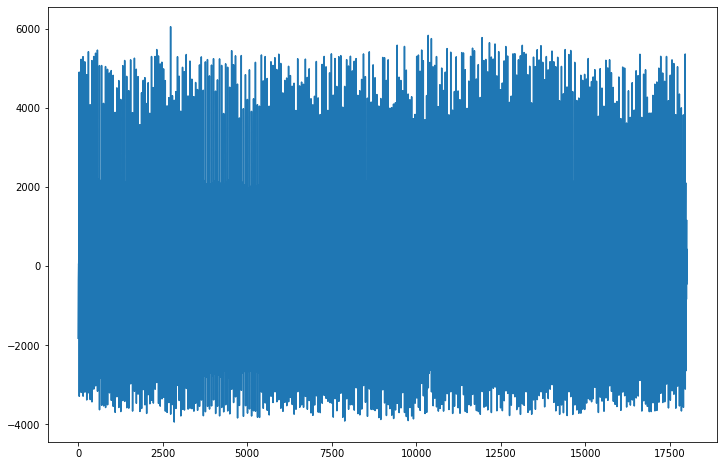

In [15]:
train_df.ECG.plot(figsize=(12, 8))

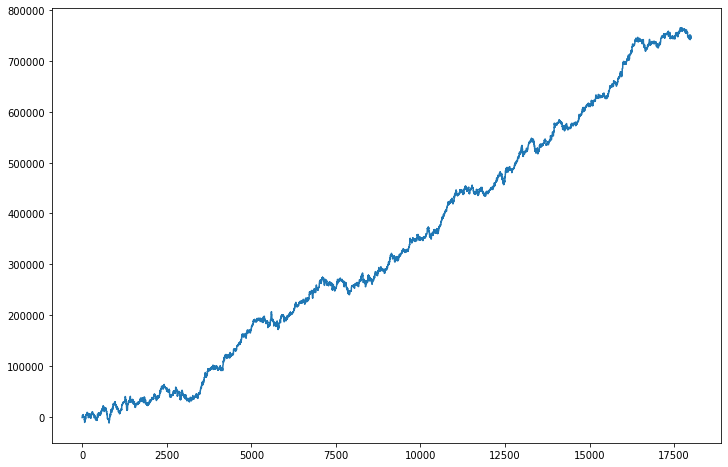

In [16]:
syn_test2.ECG.plot(figsize=(12, 8))

#### Applying the parameters for test 3: First order difference


In [41]:
# First order difference
diff_train_df = train_df.diff()
diff_train_df = diff_train_df.dropna()
diff_train_df

,EDA,ECG,Label,Left Pupil Diameter (m),Right Pupil Diameter (m),Eye Opening Left,Eye Opening Right,PERCLOS Value,Blinking,idx_col
1,0.0015,0.0287,0.0,0.000012,-0.000059,0.0157,0.0261,0.0000,0.0,1.0
2,-0.0009,0.0326,0.0,0.000014,0.000041,-0.0190,-0.0096,-0.0001,0.0,1.0
3,0.0009,0.0291,0.0,0.000159,0.000168,0.0538,0.0018,-0.0001,0.0,1.0
4,-0.0013,0.0222,0.0,-0.000079,-0.000074,-0.0790,0.0094,0.0000,0.0,1.0
5,0.0004,0.0156,0.0,0.000201,0.000530,0.0705,0.0012,-0.0001,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
17995,-0.0002,-0.0310,0.0,0.000000,0.000000,0.0000,0.0000,0.0001,0.0,1.0
17996,-0.0008,0.0375,0.0,0.000000,0.000000,0.0000,0.0151,0.0000,0.0,1.0
17997,0.0015,0.0243,0.0,0.000000,0.000000,0.0000,0.0025,0.0001,0.0,1.0
17998,-0.0024,0.0333,0.0,0.000000,0.000000,0.0000,-0.0140,0.0000,0.0,1.0


In [42]:
diff_train_df = diff_train_df.reset_index(drop=True)
diff_train_df['idx_col'] = diff_train_df.index

diff_train_df

,EDA,ECG,Label,Left Pupil Diameter (m),Right Pupil Diameter (m),Eye Opening Left,Eye Opening Right,PERCLOS Value,Blinking,idx_col
0,0.0015,0.0287,0.0,0.000012,-0.000059,0.0157,0.0261,0.0000,0.0,0
1,-0.0009,0.0326,0.0,0.000014,0.000041,-0.0190,-0.0096,-0.0001,0.0,1
2,0.0009,0.0291,0.0,0.000159,0.000168,0.0538,0.0018,-0.0001,0.0,2
3,-0.0013,0.0222,0.0,-0.000079,-0.000074,-0.0790,0.0094,0.0000,0.0,3
4,0.0004,0.0156,0.0,0.000201,0.000530,0.0705,0.0012,-0.0001,0.0,4
...,...,...,...,...,...,...,...,...,...,...
17994,-0.0002,-0.0310,0.0,0.000000,0.000000,0.0000,0.0000,0.0001,0.0,17994
17995,-0.0008,0.0375,0.0,0.000000,0.000000,0.0000,0.0151,0.0000,0.0,17995
17996,0.0015,0.0243,0.0,0.000000,0.000000,0.0000,0.0025,0.0001,0.0,17996
17997,-0.0024,0.0333,0.0,0.000000,0.000000,0.0000,-0.0140,0.0000,0.0,17997


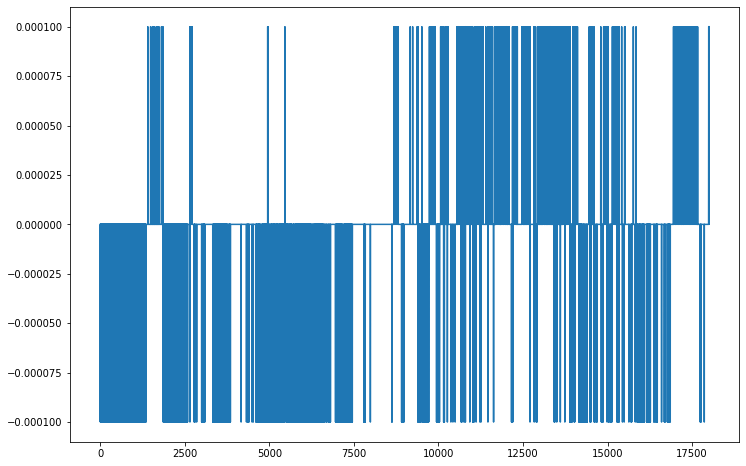

In [43]:
diff_train_df['PERCLOS Value'].plot(figsize=(12, 8))

In [44]:
# Create a project and model configuration.
project = create_project(display_name="time-series-synthetic_test3_first_order_diff_data")
# Modifying some values
config['models'][0]['synthetics']['params']['vocab_size'] = 28
config['models'][0]['synthetics']['params']['rnn_units'] = 192
config['models'][0]['synthetics']['params']['dropout_rate'] = 0.51
config['models'][0]['synthetics']['params']['gen_temp'] = 1.05
config['models'][0]['synthetics']['params']['learning_rate'] = .0099
config['models'][0]['synthetics']['params']['reset_states'] = True

syn_test3 = train_and_gen_syn_data(config, diff_train_df, project)

INFO: Starting poller


{
    "uid": "611b7248699205727827ee54",
    "model_name": "shaggy-bashful-ostrich",
    "runner_mode": "cloud",
    "user_id": "60f7ffc2bff621796155eab8",
    "project_id": "611b723d31a53d8dfe20e9a9",
    "logs": null,
    "status_history": {
        "created": "2021-08-17T08:24:40.819448Z"
    },
    "last_modified": "2021-08-17T08:24:41.078884Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/synthetics@sha256:b3e13e4cef5ffebff4251a6cd838a879ce539b05c649e517e6c45a1ba1a0d431",
    "model_type": "synthetics",
    "config": {
        "schema_version": "1.0",
        "name": null,
        "models": [
            {
                "synthetics": {
                    "params": {
                        "field_delimiter": null,
                        "epochs": 100,
                        "batch_size": 64,
   

INFO: Status is created. Model creation has been queued.
INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2021-08-17T08:24:54.245908Z  Starting synthetic model training
2021-08-17T08:24:54.247670Z  Loading training data
2021-08-17T08:24:54.680422Z  Training data loaded
{
    "record_count": 17999,
    "field_count": 10
}
2021-08-17T08:25:00.876369Z  Creating semantic validators and preparing training data
2021-08-17T08:25:09.076318Z  Beginning ML model training
2021-08-17T08:25:40.812176Z  Training epoch completed
{
    "epoch": 0,
    "accuracy": 0.4967,
    "loss": 1.6788,
    "val_accuracy": 0,
    "val_loss": 0,
    "batch": 0
}
2021-08-17T08:25:44.546481Z  Training epoch completed
{
    "epoch": 1,
    "accuracy": 0.5971,
    "loss": 1.1514,
    "val_accuracy": 0,
    "val_loss": 0,
    "batch": 0
}
2021-08-17T08:25:48.259642Z  Training epoch completed
{
    "epoch": 2,
    

{
    "uid": "611b74d37d0142d2b886295b",
    "model_name": null,
    "runner_mode": "cloud",
    "user_id": "60f7ffc2bff621796155eab8",
    "project_id": "611b723d31a53d8dfe20e9a9",
    "logs": null,
    "status_history": {
        "created": "2021-08-17T08:35:31.581000Z"
    },
    "last_modified": "2021-08-17T08:35:31.668000Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "container_image": "074762682575.dkr.ecr.us-west-2.amazonaws.com/gretelai/synthetics@sha256:b3e13e4cef5ffebff4251a6cd838a879ce539b05c649e517e6c45a1ba1a0d431",
    "model_id": "611b7248699205727827ee54",
    "action": "generate",
    "config": {
        "data_source": "gretel_b0914e87369348aa9fa7ba9426d769bf_idx_seeds.csv",
        "params": {
            "num_records": 18000,
            "max_invalid": 20000
        }
    }
}


INFO: Status is pending. A Gretel Cloud worker is being allocated to begin generating synthetic records.
INFO: Status is active. A worker has started!
2021-08-17T08:35:45.174919Z  Downloading model to worker
2021-08-17T08:35:45.565176Z  Checking for synthetic smart seeds
2021-08-17T08:35:45.774070Z  Loaded 17999 smart seeds for generation
2021-08-17T08:35:45.774988Z  Loading model
2021-08-17T08:35:47.381501Z  Generating records
{
    "num_records": 17999
}
2021-08-17T08:35:52.408092Z  Generation in progress
{
    "current_valid_count": 38,
    "current_invalid_count": 25,
    "new_valid_count": 38,
    "new_invalid_count": 25,
    "completion_percent": 0.21
}
2021-08-17T08:35:57.415685Z  Generation in progress
{
    "current_valid_count": 118,
    "current_invalid_count": 49,
    "new_valid_count": 80,
    "new_invalid_count": 24,
    "completion_percent": 0.66
}
2021-08-17T08:36:02.421548Z  Generation in progress
{
    "current_valid_count": 203,
    "current_invalid_count": 70,
    "

In [45]:
syn_test3.head()

,EDA,ECG,Label,Left Pupil Diameter (m),Right Pupil Diameter (m),Eye Opening Left,Eye Opening Right,PERCLOS Value,Blinking,idx_col
0,0.0015,0.0287,0.0,0.000012,-0.000059,0.0157,0.0261,0.0000,0.0,0
1,0.0025,0.0225,0.0,0.000012,-0.000059,-0.0053,0.1079,0.0000,0.0,1
2,0.0058,0.0287,0.0,0.000012,-0.000059,-0.0053,0.0361,0.0001,0.0,2
3,0.0082,0.0494,0.0,0.000012,-0.000059,-0.0177,0.0961,0.0001,0.0,3
4,0.0061,0.0561,0.0,0.000012,-0.000059,-0.0177,0.0961,0.0002,0.0,4


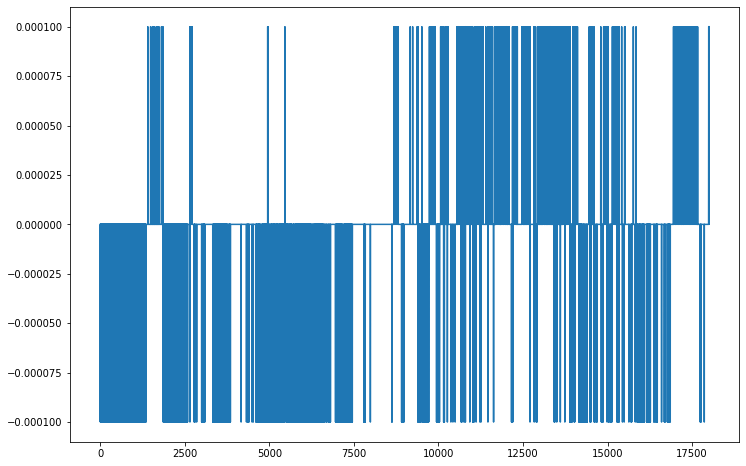

In [50]:
diff_train_df['PERCLOS Value'].plot(figsize=(12, 8))

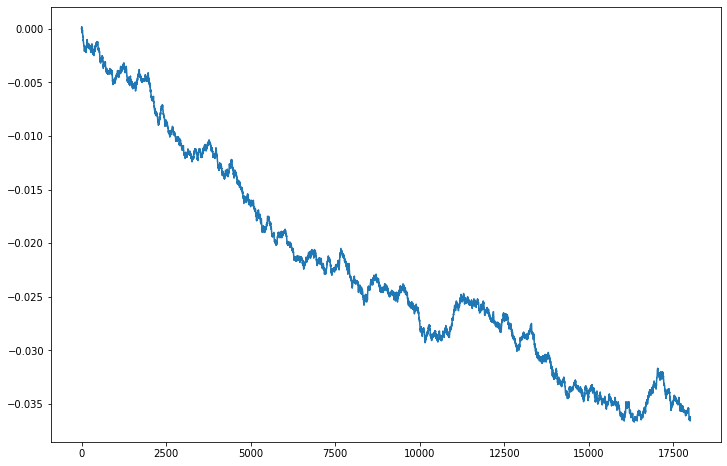

In [51]:
syn_test3['PERCLOS Value'].plot(figsize=(12, 8))